# IO, `CREATE`/`INSERT`, and External Data

## Setup

In [1]:
import ibis
import pandas as pd

con = ibis.mapd.connect(
    host='localhost', user='mapd', password='HyperInteractive',
    port=9091, database='mapd'
)

ibis.options.interactive = True

## Creating new MapD tables from Ibis expressions


Suppose you have an Ibis expression that produces a table:

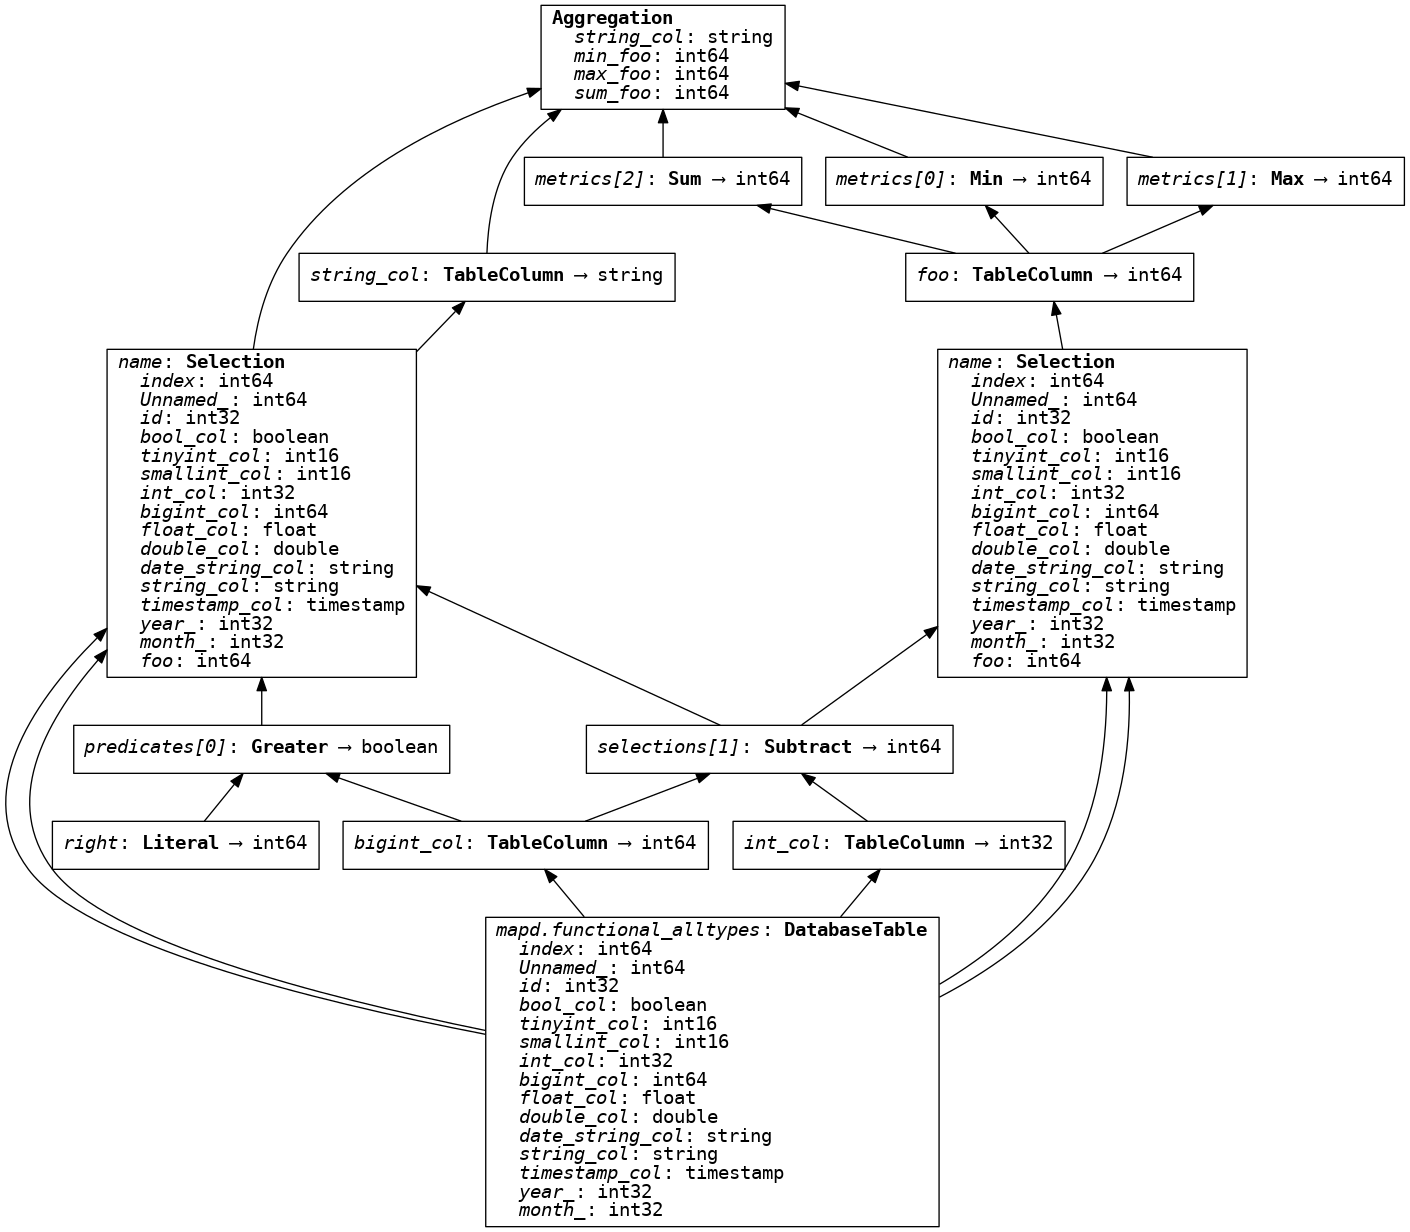

In [2]:
table = con.table('functional_alltypes')

t2 = table[table, (table.bigint_col - table.int_col).name('foo')]

expr = (t2
        [t2.bigint_col > 30]
        .group_by('string_col')
        .aggregate([t2.foo.min().name('min_foo'),
                    t2.foo.max().name('max_foo'),
                    t2.foo.sum().name('sum_foo')]))
expr

To create a table in the database from the results of this expression, use the connection's `create_table` method:

In [3]:
try:
    con.create_table('testing_table', expr, database='ibis_testing');
except Exception as e:
    print(e)

Exception: Table testing_table already exists.: CREATE TABLE testing_table
AS (
SELECT "string_col", min("foo") AS min_foo, max("foo") AS max_foo,
       sum("foo") AS sum_foo
FROM (
  SELECT *, "bigint_col" - "int_col" AS foo
  FROM mapd.functional_alltypes
  WHERE "bigint_col" > 30
) t0
GROUP BY string_col
)


Tables can be similarly dropped with `drop_table`

In [4]:
con.drop_table('testing_table', database='ibis_testing')

## Inserting data into existing MapD tables


The client's `insert` method can append new data to an existing table.

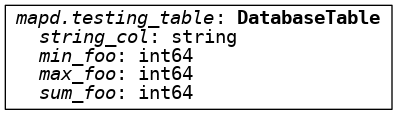

In [5]:
con.create_table('testing_table', expr)
con.table('testing_table')

In [6]:
# df = pd.DataFrame({'min_foo': [1,2,3], 'max_foo': [4, 5, 6], 'sum_foo': [4, 7, 9]})
# con.insert('testing_table', df)
# con.table('testing_table')

In [7]:
# con.drop_table('testing_table')

## Other helper functions for interacting with the database


We're adding a growing list of useful utility functions for interacting with an MapD cluster on the client object. The idea is that you should be able to do any database-admin-type work with Ibis and not have to switch over to the MapD shell. Any ways we can make this more pleasant, please let us know.

Here's some of the features, which we'll give examples for:

- Listing and searching for available databases and tables
- Creating and dropping databases
- Getting table schemas

In [8]:
con.list_tables(database='mapd')

['flights_2008_10k',
 'diamonds',
 'batting',
 'awards_players',
 'functional_alltypes',
 'testing_table']

In [9]:
con.list_tables(database='mapd', like='func*')

['functional_alltypes']

In [10]:
schema = con.get_schema('functional_alltypes')
schema

ibis.Schema {  
  index            int64
  Unnamed_         int64
  id               int32
  bool_col         boolean
  tinyint_col      int16
  smallint_col     int16
  int_col          int32
  bigint_col       int64
  float_col        float
  double_col       double
  date_string_col  string
  string_col       string
  timestamp_col    timestamp
  year_            int32
  month_           int32
}

Databases can be created:

In [11]:
db = 'ibis_testing2'
con.create_database(db, force=True)

In [12]:
# con.create_table(
#     'example_table', con.table('functional_alltypes'),
#     database=db, force=True
# )

To drop a database, including all tables in it, you can use `drop_database` with `force=True`:

In [13]:
con.drop_database(db, force=True)